In [1]:
import boto3
import json
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
import awswrangler as wr

s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

In [2]:
bucket_name = "logs-bucket-440-55865"
key = "AWSLogs"

In [3]:
# Show all files from S3
response = s3_client.list_objects_v2(
    Bucket=bucket_name,
    MaxKeys=10,
)

files = []
for file in response['Contents']:
    date_file = file['LastModified']
    now_time = datetime.now(timezone.utc)
    if file['Key'].endswith('gz') and date_file > now_time - timedelta(days=1):
        files.append(file['Key'])

In [4]:
files

['AWSLogs/600063542128/vpcdnsquerylogs/vpc-0b5dd461956ad93a2/2024/04/10/vpc-0b5dd461956ad93a2_vpcdnsquerylogs_600063542128_20240410T2220Z_fe71af19.log.gz',
 'AWSLogs/600063542128/vpcdnsquerylogs/vpc-0b5dd461956ad93a2/2024/04/10/vpc-0b5dd461956ad93a2_vpcdnsquerylogs_600063542128_20240410T2225Z_2299484c.log.gz',
 'AWSLogs/600063542128/vpcdnsquerylogs/vpc-0b5dd461956ad93a2/2024/04/10/vpc-0b5dd461956ad93a2_vpcdnsquerylogs_600063542128_20240410T2225Z_d3bcfa92.log.gz',
 'AWSLogs/600063542128/vpcdnsquerylogs/vpc-0b5dd461956ad93a2/2024/04/10/vpc-0b5dd461956ad93a2_vpcdnsquerylogs_600063542128_20240410T2230Z_039523e5.log.gz',
 'AWSLogs/600063542128/vpcdnsquerylogs/vpc-0b5dd461956ad93a2/2024/04/10/vpc-0b5dd461956ad93a2_vpcdnsquerylogs_600063542128_20240410T2230Z_df6b87f2.log.gz',
 'AWSLogs/600063542128/vpcdnsquerylogs/vpc-0b5dd461956ad93a2/2024/04/10/vpc-0b5dd461956ad93a2_vpcdnsquerylogs_600063542128_20240410T2235Z_7f7e8aa6.log.gz',
 'AWSLogs/600063542128/vpcdnsquerylogs/vpc-0b5dd461956ad93a2/202

In [22]:
df = wr.s3.read_csv(f"s3://{bucket_name}/AWSLogs/600063542128/vpcflowlogs/us-west-2/2024/04/11/", dataset=True, sep=" ")
df_protocol = pd.read_csv("https://www.iana.org/assignments/protocol-numbers/protocol-numbers-1.csv")

In [23]:
df_protocol

,Decimal,Keyword,Protocol,IPv6 Extension Header,Reference
0,0,HOPOPT,IPv6 Hop-by-Hop Option,Y,[RFC8200]
1,1,ICMP,Internet Control Message,NaN,[RFC792]
2,2,IGMP,Internet Group Management,NaN,[RFC1112]
3,3,GGP,Gateway-to-Gateway,NaN,[RFC823]
4,4,IPv4,IPv4 encapsulation,NaN,[RFC2003]
...,...,...,...,...,...
145,145,NSH,Network Service Header,N,[RFC9491]
146,146-252,NaN,Unassigned,NaN,[Internet_Assigned_Numbers_Authority]
147,253,NaN,Use for experimentation and testing,Y,[RFC3692]
148,254,NaN,Use for experimentation and testing,Y,[RFC3692]


In [26]:
df.columns

Index(['version', 'account-id', 'interface-id', 'srcaddr', 'dstaddr',
       'srcport', 'dstport', 'protocol', 'packets', 'bytes', 'start', 'end',
       'action', 'log-status', 'protocol_exp'],
      dtype='object')

In [24]:
m = df_protocol.iloc[6]

In [27]:
def protocol_func(x):
    try:
        item = df_protocol.iloc[int(x)]
        protocol = item['Protocol']
        return protocol
    except:
        return "No data"
    
df['protocol_exp'] = df.apply(lambda x: protocol_func(x.protocol), axis=1)

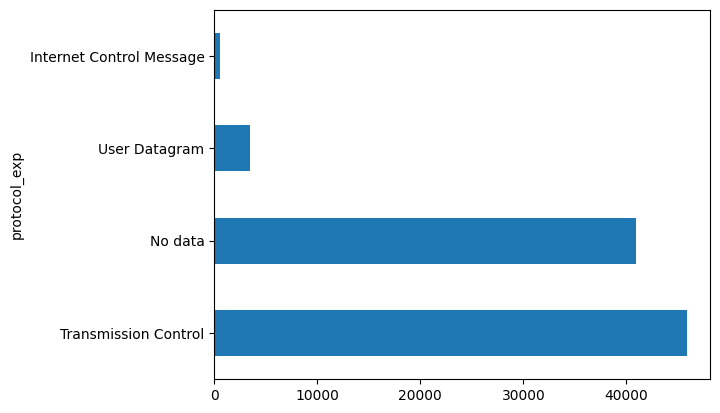

In [28]:
df.protocol_exp.value_counts().plot(kind='barh');

In [29]:
df

,version,account-id,interface-id,srcaddr,dstaddr,srcport,dstport,protocol,packets,bytes,start,end,action,log-status,protocol_exp
0,2,600063542128,eni-01b825a9284326be5,10.1.0.15,10.1.0.53,38954,443,6,16,5571,1712793541,1712793601,ACCEPT,OK,Transmission Control
1,2,600063542128,eni-04e41c1305a4b787d,-,-,-,-,-,-,-,1712793530,1712793600,-,NODATA,No data
2,2,600063542128,eni-0f6584c211597174d,-,-,-,-,-,-,-,1712793530,1712793600,-,NODATA,No data
3,2,600063542128,eni-01b825a9284326be5,10.1.0.15,10.1.0.53,40264,443,6,23,5875,1712793542,1712793602,ACCEPT,OK,Transmission Control
4,2,600063542128,eni-04e41c1305a4b787d,-,-,-,-,-,-,-,1712793528,1712793600,-,NODATA,No data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90754,2,600063542128,eni-04e41c1305a4b787d,-,-,-,-,-,-,-,1712846328,1712846400,-,NODATA,No data
90755,2,600063542128,eni-01b825a9284326be5,10.1.0.53,10.1.0.15,443,52142,6,4,519,1712846342,1712846402,ACCEPT,OK,Transmission Control
90756,2,600063542128,eni-0f6584c211597174d,10.1.1.171,10.1.0.26,57772,443,6,4,197,1712846341,1712846401,ACCEPT,OK,Transmission Control
90757,2,600063542128,eni-01b825a9284326be5,10.1.0.15,10.1.0.53,55964,443,6,18,5627,1712846346,1712846406,ACCEPT,OK,Transmission Control


In [34]:
df = wr.s3.read_json(f"s3://{bucket_name}/AWSLogs/600063542128/vpcdnsquerylogs/vpc-0b5dd461956ad93a2/2024/04/11/", dataset=True)

In [37]:
df.columns

Index(['version', 'account_id', 'region', 'vpc_id', 'query_timestamp',
       'query_name', 'query_type', 'query_class', 'rcode', 'answers',
       'srcaddr', 'srcport', 'transport', 'srcids', 'firewall_rule_action',
       'firewall_rule_group_id', 'firewall_domain_list_id'],
      dtype='object')

In [38]:
df.shape

(2733, 17)

In [39]:
df.head()

,version,account_id,region,vpc_id,query_timestamp,query_name,query_type,query_class,rcode,answers,srcaddr,srcport,transport,srcids,firewall_rule_action,firewall_rule_group_id,firewall_domain_list_id
0,1.1,600063542128,us-west-2,vpc-0b5dd461956ad93a2,2024-04-11T00:02:45Z,ssm.us-west-2.amazonaws.com.,A,IN,NOERROR,"[{'Rdata': '10.1.0.161', 'Type': 'A', 'Class':...",10.1.1.171,60908,UDP,{'instance': 'i-0f2de777b4aa850a8'},NaN,NaN,NaN
1,1.1,600063542128,us-west-2,vpc-0b5dd461956ad93a2,2024-04-11T00:03:03Z,ec2messages.us-west-2.amazonaws.com.,A,IN,NOERROR,"[{'Rdata': '10.1.0.53', 'Type': 'A', 'Class': ...",10.1.0.15,33131,UDP,{'instance': 'i-037033597f60d8129'},NaN,NaN,NaN
2,1.1,600063542128,us-west-2,vpc-0b5dd461956ad93a2,2024-04-11T00:04:04Z,ec2messages.us-west-2.amazonaws.com.,A,IN,NOERROR,"[{'Rdata': '10.1.0.53', 'Type': 'A', 'Class': ...",10.1.0.15,49050,UDP,{'instance': 'i-037033597f60d8129'},NaN,NaN,NaN
3,1.1,600063542128,us-west-2,vpc-0b5dd461956ad93a2,2024-04-11T00:04:04Z,ec2messages.us-west-2.amazonaws.com.,AAAA,IN,NOERROR,[],10.1.0.15,34329,UDP,{'instance': 'i-037033597f60d8129'},NaN,NaN,NaN
4,1.1,600063542128,us-west-2,vpc-0b5dd461956ad93a2,2024-04-11T00:04:52Z,ip-10-1-1-171.us-west-2.compute.internal.,AAAA,IN,NOERROR,[],10.1.1.171,46323,UDP,{'instance': 'i-0f2de777b4aa850a8'},NaN,NaN,NaN


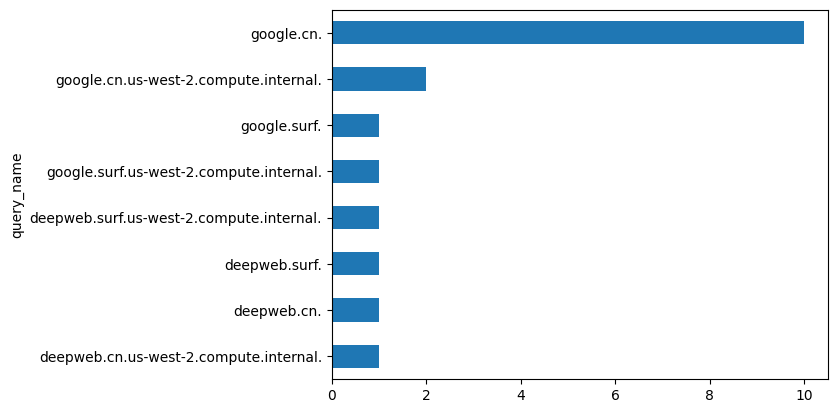

In [45]:
df_nxdomain = df[df.rcode == "NXDOMAIN"]
df_nxdomain.query_name.value_counts().head(10).plot(kind="barh").invert_yaxis();

In [42]:
df.firewall_rule_group_id.unique()

array([nan, 'rslvr-frg-5c5f01f601d944c4'], dtype=object)

In [43]:
df.firewall_rule_action.unique()

array([nan, 'BLOCK'], dtype=object)

In [44]:
df.firewall_domain_list_id.unique()

array([nan, 'rslvr-fdl-ab51ecd168e34d57'], dtype=object)

In [41]:
df.firewall_rule_action.unique()

array([nan, 'BLOCK'], dtype=object)